<a href="https://colab.research.google.com/github/erikaminarikova/REFRESH/blob/main/example_12_ordinal_sums_ostrava_data_2classes_different_learning_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pygad

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.6/89.6 kB 3.3 MB/s eta 0:00:00


In [ ]:
import pygad
import numpy as np
import pandas as pd
import statistics
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import image
import seaborn as sns

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy import stats
import time

In [ ]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, mean_squared_error

In [ ]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#ordina sums functions

# defining the generic functions for individual classes
def yes_function(x: float, y: float, a: float, kappa: float, lam: float, gamma: float = 1) -> float:
    return 1-max(0.0, (((1-x) ** kappa) + ((1-y) ** kappa) - ((1-a) ** kappa))) ** (1 / kappa)

def no_function(x: float, y: float, a: float, kappa: float, lam: float, gamma: float = 1) -> float:
        return max(0.0, ((x ** lam) + (y ** lam) - (a ** lam))) ** (1 / lam)

def maybe_function(x: float, y: float, a:float, kappa: float, lam: float, gamma: float = 1) -> float:
    if gamma == 0:
            # r = 0 means we use the geometric mean
        return 0
    elif gamma < 0:
            # r < 0 means we handle cases where x or y are 0
        if x == 0 or y == 0:
            return 0
        else:
                value = gamma*1/a*x*y+(1-gamma)*(1-1/(1-a)*(1-x)*(1-y))

    else:
            value = gamma*1/a*x*y+(1-gamma)*(1-1/(1-a)*(1-x)*(1-y))

    return statistics.median([0, 1, value])

# defining function for classification: deviding values according thir value to which fuction we use
def classification(x: float, y: float, a: float, kappa: float, lam: float, gamma: float) -> float:
    if x<a and y<a:
        value = no_function(x,y,a,1,lam,1)
    elif x>a and y>a:
        value = yes_function(x,y,a,kappa,1,1)
    else:
        value = maybe_function(x,y,a,1,1,gamma)
    return round(value,4)

In [ ]:
#alg for learning parameters in ordinal sums functions
def calculate_param_using_gen_alg(data:[] = []):
    #preparing input-output data
    df = data
    columns=len(df.columns)

    def fitness_func(ga_instance, solution, solution_idx):
        param = np.array(solution)
        df['value']=df.apply(lambda row: abs(row[0]-param[4]), axis =1)
        # parameters for attributes
        i=5
        j=0
        while j < columns-2:
            df['value']=df.apply(lambda row: classification(row['value'], abs(row[j+1]-param[i]), param[0], param[1], param[2], param[3]),
                                                            axis = 1)
            i += 1
            j += 1
        df['error']=df.apply(lambda row: math.exp2(np.abs(row['value'] - row['target']))/len(df), axis=1)
        fitness1 = 1/math.sqrt(sum(df['error']))
        df['calc_value_class'] = df.apply(lambda row: 0 if (row['value']<0.5) else 1, axis=1)
        df['target'] = df.apply(lambda row: 0 if (row['target']<0.5) else 1, axis=1)
        fitness2 = accuracy_score(df[['calc_value_class']].values, df[['target']].values)
        fitness = fitness1 + fitness2
        return fitness

    fitness_function = fitness_func

    num_generations = 60
    num_parents_mating = 12

    sol_per_pop = 24
    num_genes = 12 #number of learnt (tuned) parameters

    init_range_low = 0
    init_range_high = 1

    parent_selection_type = "sss"
    keep_parents = 2

    crossover_type = "single_point"

    mutation_type = "random"
    mutation_percent_genes = 15

    ga_instance = pygad.GA(num_generations=num_generations,
                            num_parents_mating=num_parents_mating,
                            fitness_func=fitness_function,
                            sol_per_pop=sol_per_pop,
                            num_genes=num_genes,
                            init_range_low=init_range_low,
                            init_range_high=init_range_high,
                            parent_selection_type=parent_selection_type,
                            keep_parents=keep_parents,
                            crossover_type=crossover_type,
                            mutation_type=mutation_type,
                            mutation_percent_genes=mutation_percent_genes,
                            gene_space=[{'low': 0, 'high': 1},{'low': 0, 'high': 3},
                                        {'low': 0, 'high': 3},{'low': 0, 'high': 1},
                                        [0,1], [0,1], [0,1], [0,1],
                                        [0,1], [0,1], [0,1], [0,1]])

    ga_instance.run()

    ga_instance.plot_fitness()

    solution, solution_fitness, solution_idx = ga_instance.best_solution()

    #filename = 'genetic'
    #ga_instance.save(filename=filename)

    solution_param= np.array(solution)
    df['calc_value']=df.apply(lambda row: abs(row[0]-solution_param[4]), axis = 1)
    columns=len(df.columns)
    j=0
    i=5
    while j < columns-6:
        df['calc_value']=df.apply(lambda row: classification(row['calc_value'], abs(row[j+1] - solution_param[i]), solution_param[0], solution_param[1], solution_param[2], solution_param[3]),
                                                        axis = 1)
        i += 1
        j += 1

    merge_data = df
    # merge_data.to_csv("data/output.csv")
    mean_error = (sum(merge_data['error'])) / len(merge_data)
    kappa_result = solution_param[1]
    lam_result = solution_param[2]
    gamma_result = solution_param[3]
    a_result = solution_param[0]
    return merge_data, mean_error, kappa_result, lam_result, gamma_result, a_result, solution_param, solution_fitness, solution_idx



In [ ]:
# Optimized and safe version
import numpy as np
import math
import pygad
import statistics
import pandas as pd
from sklearn.metrics import f1_score

# ---- Ordinal Sums Functions ---- #
def yes_function(x, y, a, kappa, lam, gamma=1):
    return 1 - np.maximum(0.0, ((1-x)**kappa + (1-y)**kappa - (1-a)**kappa))**(1/kappa)

def no_function(x, y, a, kappa, lam, gamma=1):
    return np.maximum(0.0, (x**lam + y**lam - a**lam))**(1/lam)

def maybe_function(x, y, a, kappa, lam, gamma=1):
    if x is None or y is None:
        return 0
    if gamma == 0:
        return 0
    else:
        value = gamma*(1/a)*x*y + (1-gamma)*(1 - (1/(1-a))*(1-x)*(1-y))
    return statistics.median([0, 1, value])

def classification(x, y, a, kappa, lam, gamma):
    if x < a and y < a:
        return no_function(x, y, a, 1, lam, 1)
    elif x > a and y > a:
        return yes_function(x, y, a, kappa, 1, 1)
    else:
        return maybe_function(x, y, a, 1, 1, gamma)

# ---- Vectorized wrapper ---- #
def classification_vec(values, diffs, a, kappa, lam, gamma):
    if values.size == 0 or diffs.size == 0:
        return np.zeros_like(values)

    results = np.zeros_like(values)
    mask_no = (values < a) & (diffs < a)
    mask_yes = (values > a) & (diffs > a)
    mask_maybe = ~(mask_no | mask_yes)

    if np.any(mask_no):
        results[mask_no] = no_function(values[mask_no], diffs[mask_no], a, 1, lam, 1)
    if np.any(mask_yes):
        results[mask_yes] = yes_function(values[mask_yes], diffs[mask_yes], a, kappa, 1, 1)
    if np.any(mask_maybe):
        for idx in np.where(mask_maybe)[0]:
            results[idx] = maybe_function(values[idx], diffs[idx], a, 1, 1, gamma)

    return np.round(results, 4)

# ---- Genetic Algorithm ---- #
def calculate_param_using_gen_alg(data: pd.DataFrame):
    df = data.copy()
    X = df.iloc[:, :-1].to_numpy()
    y = df.iloc[:, -1].to_numpy()
    n_features = X.shape[1]

    def fitness_func(ga_instance, solution, solution_idx):
        try:
            param = np.array(solution, dtype=float)
            value = np.abs(X[:, 0] - param[5])
            i = 6
            for j in range(n_features-1):
                diff = np.abs(X[:, j+1] - param[i])
                value = classification_vec(value, diff,
                                           param[0], param[1], param[2], param[3])
                i += 1

            error = np.exp2(np.abs(value - y))
            fitness1 = 1.0 / (math.sqrt(np.mean(error)) + 1e-8)  # avoid division by zero

            calc_class = (value >= param[0]).astype(int)
            target_class = (y >= param[0]).astype(int)
            fitness2 = f1_score(target_class, calc_class)

            if np.isnan(fitness1) or np.isnan(fitness2):
                return 0

            return param[4]*fitness1 + (1-param[4])*fitness2

        except Exception as e:
            print(f"Fitness calculation failed: {e}")
            return 0

    ga_instance = pygad.GA(
        num_generations=60,
        num_parents_mating=12,
        fitness_func=fitness_func,
        sol_per_pop=24,
        num_genes=13,
        init_range_low=0,
        init_range_high=1,
        parent_selection_type="tournament",
        K_tournament=3,
        keep_parents=2,
        crossover_type="single_point",
        mutation_type="random",
        mutation_percent_genes=15,
        gene_space=[
            {'low': 0.3, 'high': 0.7},   # a
            {'low': 0, 'high': 3},       # kappa
            {'low': 0, 'high': 3},       # lambda
            {'low': 0, 'high': 1},       # gamma
            {'low': 0, 'high': 1},       # fitness weight
            *([[0,1]] * 8)               # binary params
        ]
    )

    ga_instance.run()
    solution, solution_fitness, solution_idx = ga_instance.best_solution()

    best_params = np.array(solution, dtype=float)
    value = np.abs(X[:, 0] - best_params[5])
    i = 6
    for j in range(n_features-1):
        diff = np.abs(X[:, j+1] - best_params[i])
        value = classification_vec(value, diff,
                                   best_params[0], best_params[1], best_params[2], best_params[3])
        i += 1

    error = np.exp2(np.abs(value - y))
    calc_class = (value >= best_params[0]).astype(int)
    target_class = (y >= best_params[0]).astype(int)

    df["calc_value"] = value
    df["error"] = error
    df["calc_value_class"] = calc_class
    df["target_class"] = target_class

    mean_error = np.mean(error)

    return (
        df,                # dataset with calc values
        mean_error,
        best_params[1],    # kappa
        best_params[2],    # lambda
        best_params[3],    # gamma
        best_params[0],    # a
        best_params,       # full parameter vector
        solution_fitness,
        solution_idx
    )


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Fuction to despay relevant results
def show_results(data, mean_error, gamma_result, lam_result, kappa_result, a_result):
    # calculate the mean squared error
    target_values = data[['target']].values
    value = data[['calc_value']].values
    MSE = mean_squared_error(target_values, value)
    RMSE = math.sqrt(MSE)
    # print the results
    print('Results:')
    if all(col in data.columns for col in ['value','error']):
      print(data.drop(columns=['value','error']))
    else:
      print(data)
    #print('mean error: ', mean_error)
    print('\u03B3 = ', round(gamma_result, 4))
    print('\u03BB = ', round(lam_result, 4))
    print('\u03BA = ', round(kappa_result, 4))
    print('a = ', round(a_result, 4))
    print('Mean squared error = ', round(MSE, 4))
    print('Root Mean Square Error = ', round(RMSE, 4))

In [ ]:
def print_attr_coef(sol_param):
  coeficients = []
  for i in sol_param:
    if i == 1:
      pom = '1-decreasing'
      coeficients.append(pom)
    elif i == 0:
      pom = '0-increasing'
      coeficients.append(pom)

  name_columns = data_reordered.drop(columns=['target']).columns

  merge_list = name_columns + [': '] + coeficients
  for list in merge_list:
    print(list)

In [ ]:
def view_chart(a, kappa, lam):
    """ if df:
        variables_for_plot = st.multiselect('Select 2 dependent variables for plot:', df.columns, max_selections=2)
        if variables_for_plot:
            df_for_plot = df[variables_for_plot]
            x=df_for_plot.iloc[:, 0]
            y=df_for_plot.iloc[:, 1]
            plt.scatter(x,y) """
    plt.figure(figsize=(3, 3))
    plt.subplot(111)
    y = np.arange(0, 1, 0.05)
    x = [a] * len(y)
    plt.scatter(x, y, c = 'black', s = 1)

    x = np.arange(0, 1, 0.05)
    y = [a] * len(x)
    plt.scatter(x, y, c = 'black', s = 1)

    y1 = np.arange(a, 1.0, 0.001)
    b=1
    x1 = 1-((1-a)**kappa-(1-y1)**kappa)**(1/kappa)
    plt.plot(x1, y1, c = 'red')
    plt.fill_between(y1,x1, b, color='red')

    y2 = np.arange(0, a, 0.01)
    x2 = ((a**lam)-(y2**lam))**(1/lam)
    plt.plot(y2, x2, c = 'green')
    plt.fill_between(y2,x2,color='green')

    # y3 = np.arange(a, 1.01, 0.01)
    # x3 = 1-(((1-a)**kappa)-((1-y3)**kappa))**(1/kappa)
    # z = np.min(b, x2)
    # plt.fill_between(y3,x3,y2=0, color='blue')

    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.annotate('D', xy=(a, a), xytext=(a + 0.2, a + 0.2), fontsize=12)
    plt.annotate('C', xy=(a, a), xytext=(a - 0.3, a - 0.3), fontsize=12)
    plt.annotate('Avg', xy=(a, a), xytext=(a - 0.3, a + 0.2), fontsize=12)
    plt.annotate('Avg', xy=(a, a), xytext=(a + 0.2, a - 0.3), fontsize=12)

    plt.annotate('a', xy=(a, a), xytext=(a - 0.04, a - 0.63), fontsize=12)
    plt.annotate('a', xy=(a, a), xytext=(a - 0.63, a - 0.04), fontsize=12)

    return (plt)

In [ ]:
from sklearn.datasets import fetch_california_housing

#getting the data from sciki learn
california_housing = fetch_california_housing(as_frame=True)
df = california_housing.frame

In [ ]:
#identify outliers
z = np.abs(stats.zscore(df))
threshold = 3
#remove outliers
df_o = df[(z<3).all(axis=1)]

In [ ]:
# normalize the data
columns = df_o.columns
scaler = MinMaxScaler()
model = scaler.fit_transform(df_o)
df_scaled = pd.DataFrame(model, columns = columns)

In [ ]:
print(df.shape)
print(df_o.shape)

(20640, 9)
(19794, 9)


In [ ]:
df_scaled.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,19794.000000,19794.000000,19794.000000,19794.000000,19794.000000,19794.000000,19794.000000,19794.000000,19794.000000
mean,0.356940,0.548464,0.379039,0.337248,0.278539,0.065694,0.329026,0.486415,0.386775
std,0.177179,0.244083,0.105298,0.062056,0.168561,0.026643,0.227111,0.204472,0.228364
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.225757,0.352941,0.307837,0.308126,0.163829,0.050492,0.147715,0.260204,0.213197
50%,0.331276,0.549020,0.374044,0.327725,0.240656,0.062238,0.182784,0.596939,0.336289
75%,0.459503,0.705882,0.441738,0.350689,0.351537,0.076327,0.550478,0.645918,0.505309
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


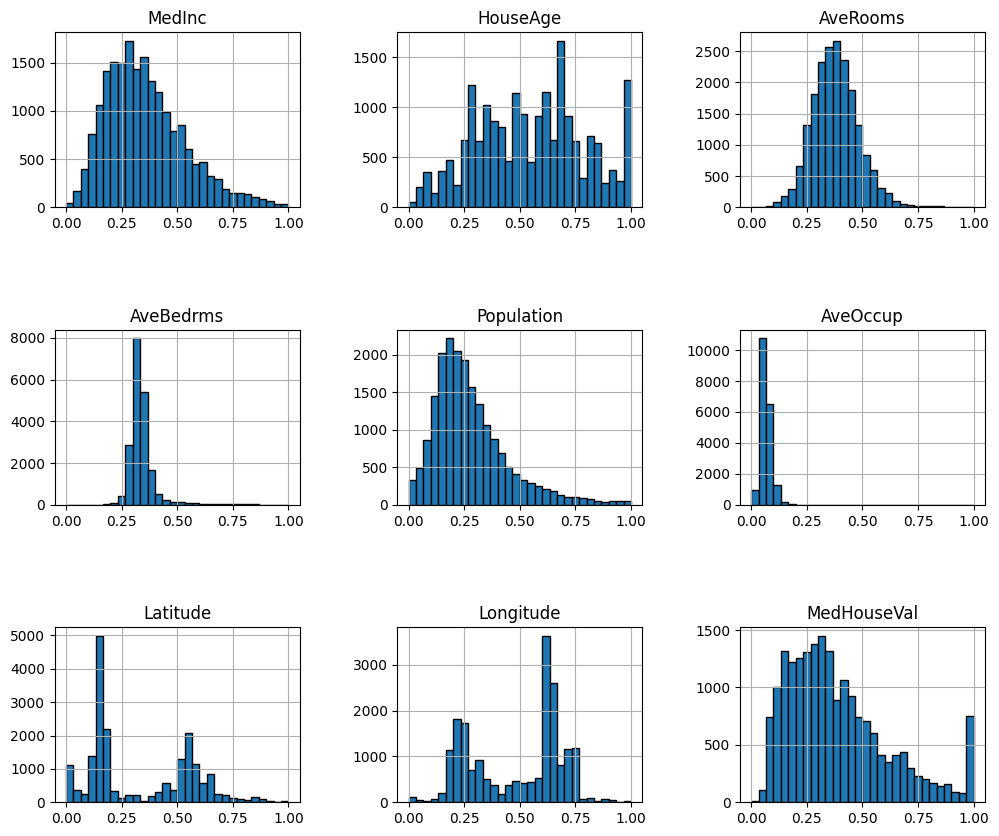

In [ ]:
# Grafical representation of distribution of attributes
df_scaled.hist(figsize=(12, 10), bins=30, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)

In [ ]:
def plot_map(data):
  sns.scatterplot(
      data=data,
      x="Longitude",
      y="Latitude",
      size="MedHouseVal",
      hue="MedHouseVal",
      palette="viridis",
      alpha=0.5,
  )
  plt.legend(title="MedHouseVal", bbox_to_anchor=(1.05, 0.95), loc="upper left")
  _ = plt.title("Median house value depending of\n their spatial location")

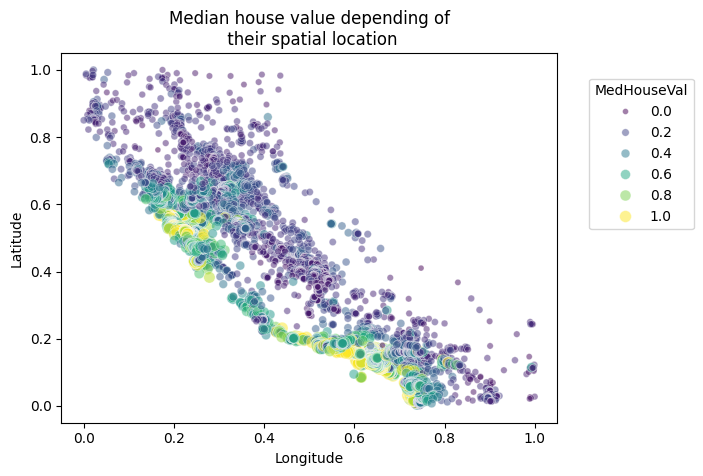

In [ ]:
plot_map(df_scaled)

In [ ]:
#prepare data for ordinal sums - identify target value - classification into 2 classes
data = df_scaled[['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']]
data['target'] = df_scaled['MedHouseVal']

In [ ]:
data_reordered = data.iloc[:,[1,2,3,4,5,6,7,0,8]]

In [ ]:
df_train, df_test = train_test_split(data_reordered, test_size=0.20, random_state=2)

In [ ]:
start_time = time.time()
merge_data, mean_error, kappa_result, lam_result, gamma_result, a_result, sol_param, solution_fitness, solution_idx = calculate_param_using_gen_alg(df_train)

show_results(merge_data, mean_error, gamma_result, lam_result, kappa_result, a_result)
print_attr_coef(sol_param)
print("wages: {w1}, {w2}".format(w1=sol_param[4], w2=1-sol_param[4]))
print("Parameters of the best solution : {solution_idx}".format(solution_idx=solution_idx))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

print('time:', (time.time()-start_time)/60)

Results:
       HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
14747  0.372549  0.411649   0.285927    0.242940  0.078639  0.072264   
16646  0.450980  0.307137   0.375297    0.293397  0.081938  0.257173   
9739   0.607843  0.453493   0.272503    0.268480  0.068397  0.146652   
5738   0.294118  0.395933   0.285073    0.273256  0.066482  0.167906   
9812   0.215686  0.326020   0.415597    0.211586  0.081399  0.140276   
...         ...       ...        ...         ...       ...       ...   
1099   0.431373  0.349409   0.314570    0.162998  0.043520  0.768332   
18898  0.490196  0.426587   0.316905    0.232973  0.069987  0.705632   
11798  0.137255  0.487566   0.473805    0.094269  0.046577  0.113709   
6637   0.490196  0.329658   0.337992    0.146595  0.103021  0.162593   
2575   0.294118  0.479153   0.599544    0.168812  0.052799  0.816153   

       Longitude    MedInc    target  calc_value     error  calc_value_class  \
14747   0.725510  0.401018  0.304125      0.29

In [ ]:
def calculate_tests(target_values, value):
  print('Accuracy score = ', accuracy_score(target_values, value))
  print('F1 = ', f1_score(target_values, value, average= 'macro'))
  print('Precision = ', precision_score(target_values, value, average= 'macro'))
  print('Recall = ', recall_score(target_values, value, average= 'macro'))
  #confusion matrix
  confusion_matrix = metrics.confusion_matrix(target_values, value)
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
  cm_display.plot()
  plt.show()

In [ ]:
# for testing_df
merge_data['calc_value_class'] = merge_data.apply(lambda row: 0 if (row['calc_value']<=a_result) else 1, axis=1)
merge_data['target_class'] = merge_data.apply(lambda row: 0 if (row['target']<=a_result) else 1, axis=1)

Accuracy score =  0.8744553204925797
F1 =  0.7281346355519841
Precision =  0.6885195654606722
Recall =  0.8274966091241824


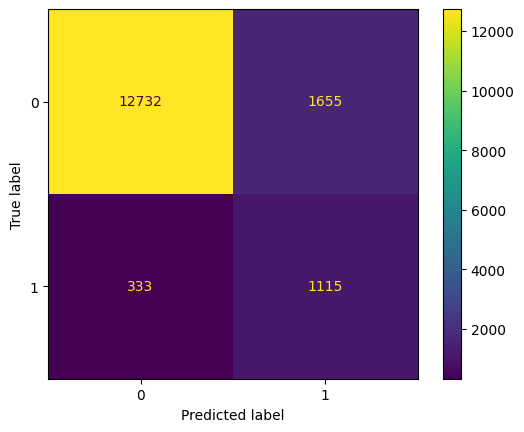

In [ ]:
# tests for train dataset: testing_df
calculate_tests(merge_data[["calc_value_class"]].values, merge_data[['target_class']].values)

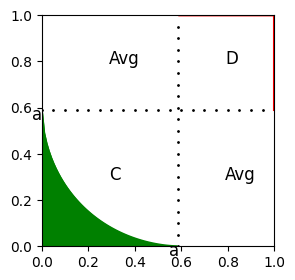

In [ ]:
# df = pd.DataFrame()
# chart = view_chart(df, 0.2305, 0.8658, 3.7278, 0.9559)
# chart = view_chart(0.5,1,1)

chart = view_chart(a_result, lam_result, kappa_result)
chart.show()

In [ ]:
#to know -2 or -5 in loop - remove additional columns
df_test

,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedInc,target
17298,0.666667,0.511942,0.324788,0.386836,0.058391,0.497343,0.243878,0.882500,1.000000
17930,0.176471,0.506048,0.367698,0.219684,0.075735,0.859724,0.205102,0.351737,0.281650
4031,0.843137,0.264338,0.377597,0.249377,0.082824,0.166844,0.629592,0.209635,0.282887
3699,0.235294,0.241546,0.313634,0.387043,0.047524,0.176408,0.601020,0.334092,0.387011
17294,0.392157,0.676985,0.333466,0.375415,0.074810,0.497343,0.246939,0.980930,1.000000
...,...,...,...,...,...,...,...,...,...
8117,0.627451,0.288749,0.334220,0.314576,0.079235,0.153029,0.612245,0.289249,0.284125
9300,0.313725,0.322019,0.354482,0.115656,0.046534,0.483528,0.339796,0.168029,0.201032
12110,0.647059,0.410729,0.377545,0.175457,0.060875,0.636557,0.295918,0.217994,0.148455
16168,0.666667,0.270663,0.324645,0.124377,0.060964,0.540914,0.197959,0.276065,0.441444


In [ ]:
# Calculate ordinal sums on test dataset
columns=len(df_test.columns)
df_test['calc_value']=df_test.apply(lambda row: abs(sol_param[5]-row[0]), axis =1)
# parameters for attributes
i=6
j=0
while j < columns-2:
  df_test['calc_value']=df_test.apply(lambda row: classification(row['calc_value'], abs(row[j+1]-sol_param[i]), sol_param[0], sol_param[1], sol_param[2], sol_param[3]), axis = 1)
  i += 1
  j += 1
show_results(df_test, 0, 0, 0, 0, 0)

Results:
       HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
5166   0.588235  0.291799   0.328154    0.318106  0.050678  0.159405   
18885  0.392157  0.287099   0.345432    0.309593  0.122093  0.699256   
17221  0.372549  0.402965   0.337405    0.423380  0.053526  0.507970   
18750  0.686275  0.341910   0.350643    0.424003  0.089395  0.538789   
8494   0.686275  0.427784   0.330500    0.232973  0.057323  0.136026   
...         ...       ...        ...         ...       ...       ...   
17880  0.549020  0.456346   0.416375    0.274917  0.048400  0.468650   
18059  0.274510  0.439965   0.381262    0.445183  0.050477  0.939426   
3978   0.686275  0.451192   0.325917    0.459510  0.036475  0.168969   
524    1.000000  0.344085   0.354447    0.102367  0.046571  0.556854   
12034  0.843137  0.396529   0.324235    0.163621  0.046464  0.637620   

       Longitude    MedInc    target  calc_value  
5166    0.603061  0.283949  0.686185    0.356727  
18885   0.280612  0.0921

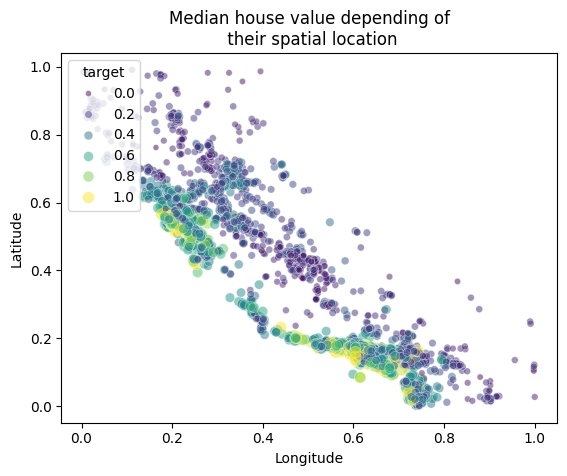

In [ ]:
sns.scatterplot(
      data=merge_data,
      x="Longitude",
      y="Latitude",
      size="target",
      hue="target",
      palette="viridis",
      alpha=0.5,
  )
plt.legend(title="target", loc="upper left")
_ = plt.title("Median house value depending of\n their spatial location")

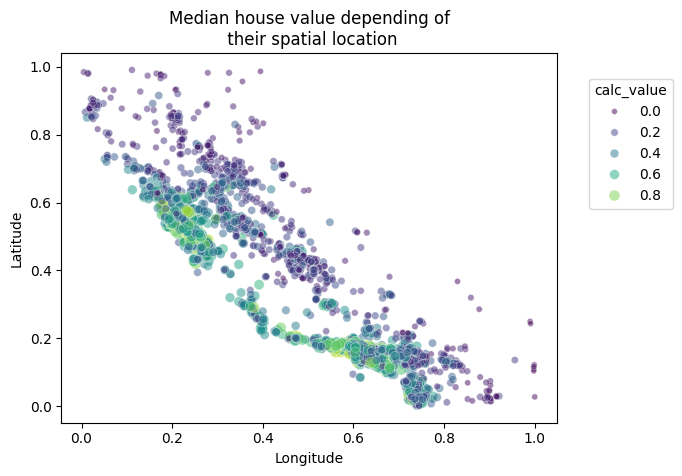

In [ ]:
sns.scatterplot(
      data=merge_data,
      x="Longitude",
      y="Latitude",
      size="calc_value",
      hue="calc_value",
      palette="viridis",
      alpha=0.5,
  )
plt.legend(title="calc_value", bbox_to_anchor=(1.05, 0.95), loc="upper left")
_ = plt.title("Median house value depending of\n their spatial location")

In [ ]:
#label calculated value in test dataset to the 2 clasees yes-1, no -0
df_test['target_class'] = df_test.apply(lambda row: 0 if (row['target']<a_result)else 1, axis=1)
df_test['calc_value_class'] = df_test.apply(lambda row: 0 if (row['calc_value']<a_result)else 1, axis=1)

In [ ]:
df_test

,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedInc,target,calc_value,target_class,calc_value_class
17298,0.666667,0.511942,0.324788,0.386836,0.058391,0.497343,0.243878,0.882500,1.000000,0.457103,1,0
17930,0.176471,0.506048,0.367698,0.219684,0.075735,0.859724,0.205102,0.351737,0.281650,0.126920,0,0
4031,0.843137,0.264338,0.377597,0.249377,0.082824,0.166844,0.629592,0.209635,0.282887,0.165329,0,0
3699,0.235294,0.241546,0.313634,0.387043,0.047524,0.176408,0.601020,0.334092,0.387011,0.154387,0,0
17294,0.392157,0.676985,0.333466,0.375415,0.074810,0.497343,0.246939,0.980930,1.000000,0.449137,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
8117,0.627451,0.288749,0.334220,0.314576,0.079235,0.153029,0.612245,0.289249,0.284125,0.129755,0,0
9300,0.313725,0.322019,0.354482,0.115656,0.046534,0.483528,0.339796,0.168029,0.201032,0.101294,0,0
12110,0.647059,0.410729,0.377545,0.175457,0.060875,0.636557,0.295918,0.217994,0.148455,0.064935,0,0
16168,0.666667,0.270663,0.324645,0.124377,0.060964,0.540914,0.197959,0.276065,0.441444,0.302096,0,0


In [ ]:
#prepare test data for tests
target_values = df_test[['target_class']].values
value = df_test[['calc_value_class']].values

Accuracy score =  0.8848193988380905
F1 =  0.7480312059303327
Precision =  0.8412663261299016
Recall =  0.7066469870168768


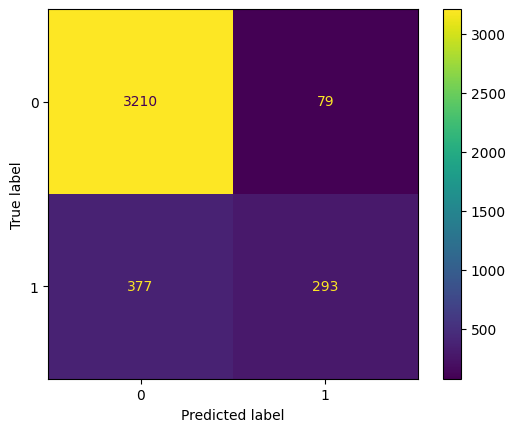

In [ ]:
# tests for test dataset:
calculate_tests(target_values, value)

In [ ]:
merge_data

,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedInc,target,value,error,calc_value,target_class,calc_value_class
2563,0.627451,0.419414,0.301746,0.118355,0.050537,0.853348,0.024490,0.219706,0.121857,0.0,0.121857,0.1620,0,0
52,0.784314,0.312679,0.390317,0.406146,0.059357,0.561105,0.212245,0.067457,0.170104,0.0,0.170104,0.2594,0,0
18988,0.431373,0.394933,0.342125,0.111296,0.058175,0.850159,0.125510,0.151244,0.095878,0.0,0.095878,0.0852,0,0
16432,0.725490,0.514570,0.302184,0.279693,0.053838,0.519660,0.219388,0.758398,1.000000,0.0,1.000000,0.9044,1,1
17218,0.529412,0.409990,0.323061,0.437500,0.050624,0.505845,0.240816,0.513284,0.674226,0.0,0.674226,0.7474,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099,0.431373,0.349409,0.314570,0.162998,0.043520,0.768332,0.278571,0.144939,0.161857,0.0,0.161857,0.0709,0,0
18898,0.490196,0.426587,0.316905,0.232973,0.069987,0.705632,0.273469,0.319770,0.164125,0.0,0.164125,0.2217,0,0
11798,0.137255,0.487566,0.473805,0.094269,0.046577,0.113709,0.803061,0.266867,0.206805,0.0,0.206805,0.1161,0,0
6637,0.490196,0.329658,0.337992,0.146595,0.103021,0.162593,0.638776,0.295389,0.321238,0.0,0.321238,0.2151,0,0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
merge_data.to_csv('/content/drive/MyDrive/Colab Notebooks/os_final_output.csv')

In [ ]:
df_test.to_csv('/content/drive/MyDrive/Colab Notebooks/os_final_output_test.csv')